Epoca: 1, loss = 0.5216349363327026
Epoca: 10, loss = 0.07317821681499481
Epoca: 20, loss = 0.010423536412417889
Epoca: 30, loss = 0.007241867482662201
Epoca: 40, loss = 0.003058446105569601
Epoca: 50, loss = 0.001446791342459619
Epoca: 60, loss = 0.0003942840558011085
Epoca: 70, loss = 0.000133213892695494
Epoca: 80, loss = 0.00015234328748192638
Epoca: 90, loss = 0.0001210587506648153
Epoca: 100, loss = 0.00011616775736911222
Epoca: 110, loss = 0.00010831954568857327
Epoca: 120, loss = 0.00010400882456451654
Epoca: 130, loss = 0.00010217002272838727
Epoca: 140, loss = 0.00010039630433311686
Epoca: 150, loss = 9.882958693196997e-05
Epoca: 160, loss = 9.735014464240521e-05
Epoca: 170, loss = 9.588192187948152e-05
Epoca: 180, loss = 9.444596071261913e-05
Epoca: 190, loss = 9.302105900133029e-05
Epoca: 200, loss = 9.16076751309447e-05
Epoca: 210, loss = 9.0203364379704e-05
Epoca: 220, loss = 8.880851964931935e-05
Epoca: 230, loss = 8.742146019358188e-05
Epoca: 240, loss = 8.6042018665466

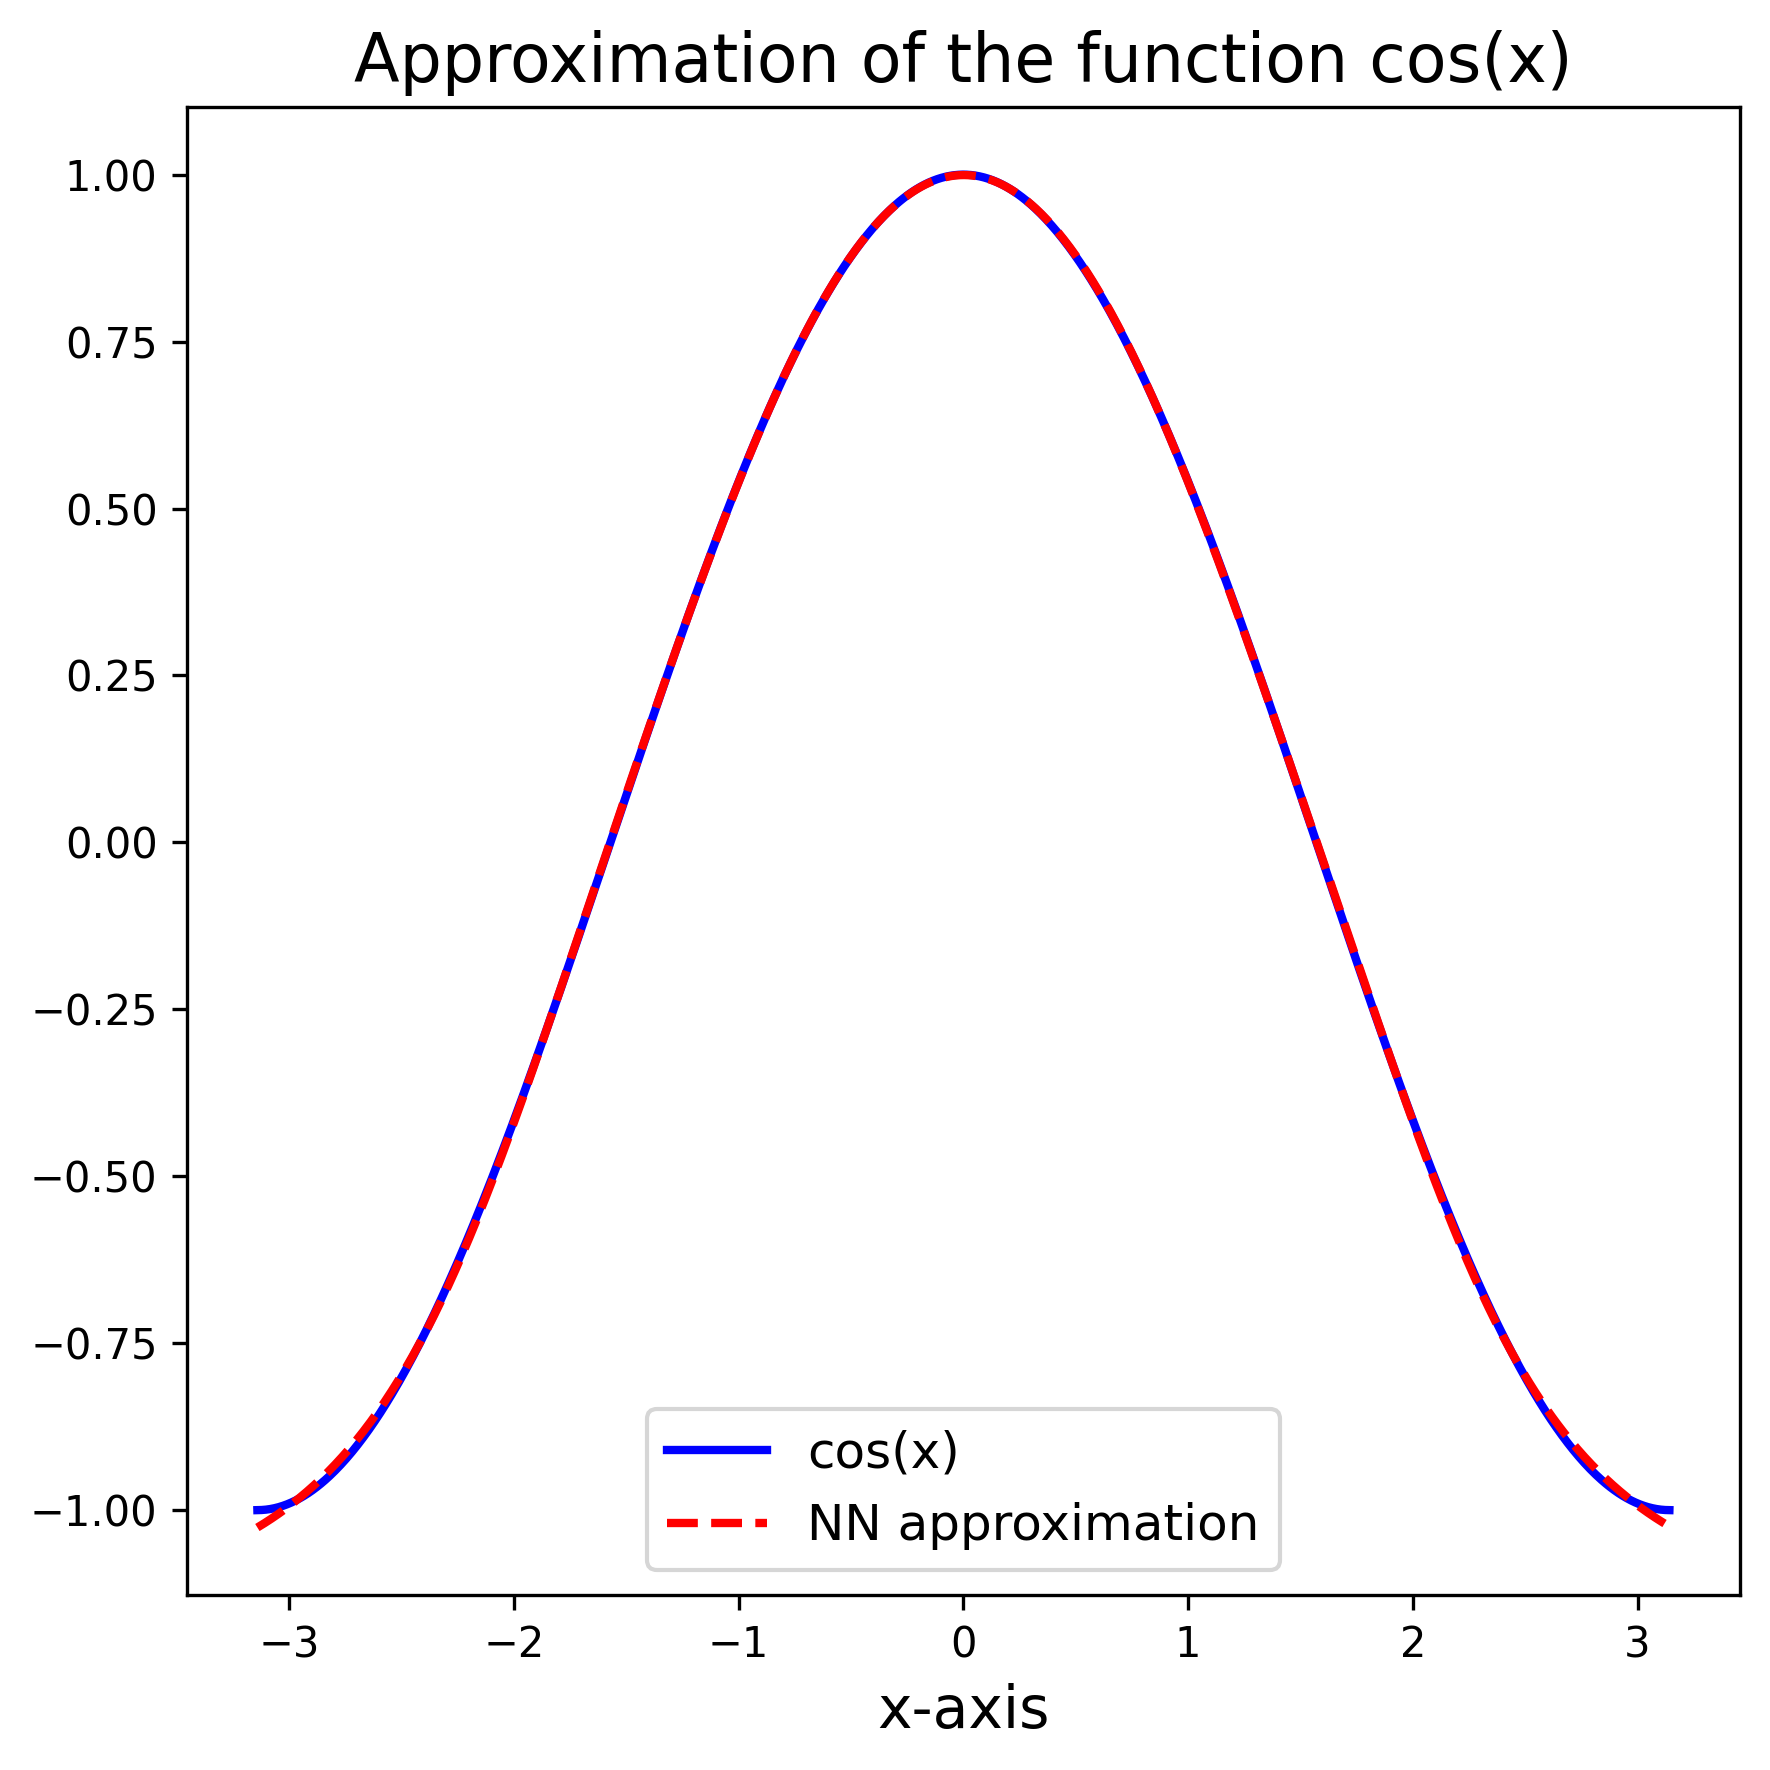

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Imposta il seed per la riproducibilità
torch.manual_seed(0)

# Crea i dati di input
x_np = np.linspace(-np.pi, np.pi, 1000).reshape(-1, 1)
y_np = np.cos(x_np)

# Convertili in tensori PyTorch
x = torch.tensor(x_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.float32)

# Definisci la rete neurale
class CosineApproximator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.net(x)

model = CosineApproximator()

# Loss e ottimizzatore
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Addestramento
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    if epoch ==0 or (epoch+1) %10==0 or epoch == epochs-1:
        print(f"Epoca: {epoch+1}, loss = {loss}")
    loss.backward()
    optimizer.step()

# Predizione
model.eval()
with torch.no_grad():
    y_pred = model(x).numpy()

# Plot ad alta qualità
plt.figure(figsize=(6, 6), dpi=300)
plt.plot(x_np, y_np, label='cos(x)', color='blue', linewidth=2)
plt.plot(x_np, y_pred, label='NN approximation', color='red', linestyle='--', linewidth=2)
plt.title('Approximation of the function cos(x)', fontsize=16)
plt.xlabel('x-axis', fontsize=14)
plt.ylabel('', fontsize=14)
plt.grid(False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


Epoca: 1, loss = tensor([[1.6723]], grad_fn=<AddBackward0>)
Epoca: 10, loss = tensor([[0.7494]], grad_fn=<AddBackward0>)
Epoca: 20, loss = tensor([[0.2564]], grad_fn=<AddBackward0>)
Epoca: 30, loss = tensor([[0.0889]], grad_fn=<AddBackward0>)
Epoca: 40, loss = tensor([[0.0713]], grad_fn=<AddBackward0>)
Epoca: 50, loss = tensor([[0.0630]], grad_fn=<AddBackward0>)
Epoca: 60, loss = tensor([[0.0468]], grad_fn=<AddBackward0>)
Epoca: 70, loss = tensor([[0.0360]], grad_fn=<AddBackward0>)
Epoca: 80, loss = tensor([[0.0289]], grad_fn=<AddBackward0>)
Epoca: 90, loss = tensor([[0.0226]], grad_fn=<AddBackward0>)
Epoca: 100, loss = tensor([[0.0175]], grad_fn=<AddBackward0>)
Epoca: 110, loss = tensor([[0.0136]], grad_fn=<AddBackward0>)
Epoca: 120, loss = tensor([[0.0106]], grad_fn=<AddBackward0>)
Epoca: 130, loss = tensor([[0.0083]], grad_fn=<AddBackward0>)
Epoca: 140, loss = tensor([[0.0067]], grad_fn=<AddBackward0>)
Epoca: 150, loss = tensor([[0.0055]], grad_fn=<AddBackward0>)
Epoca: 160, loss = 

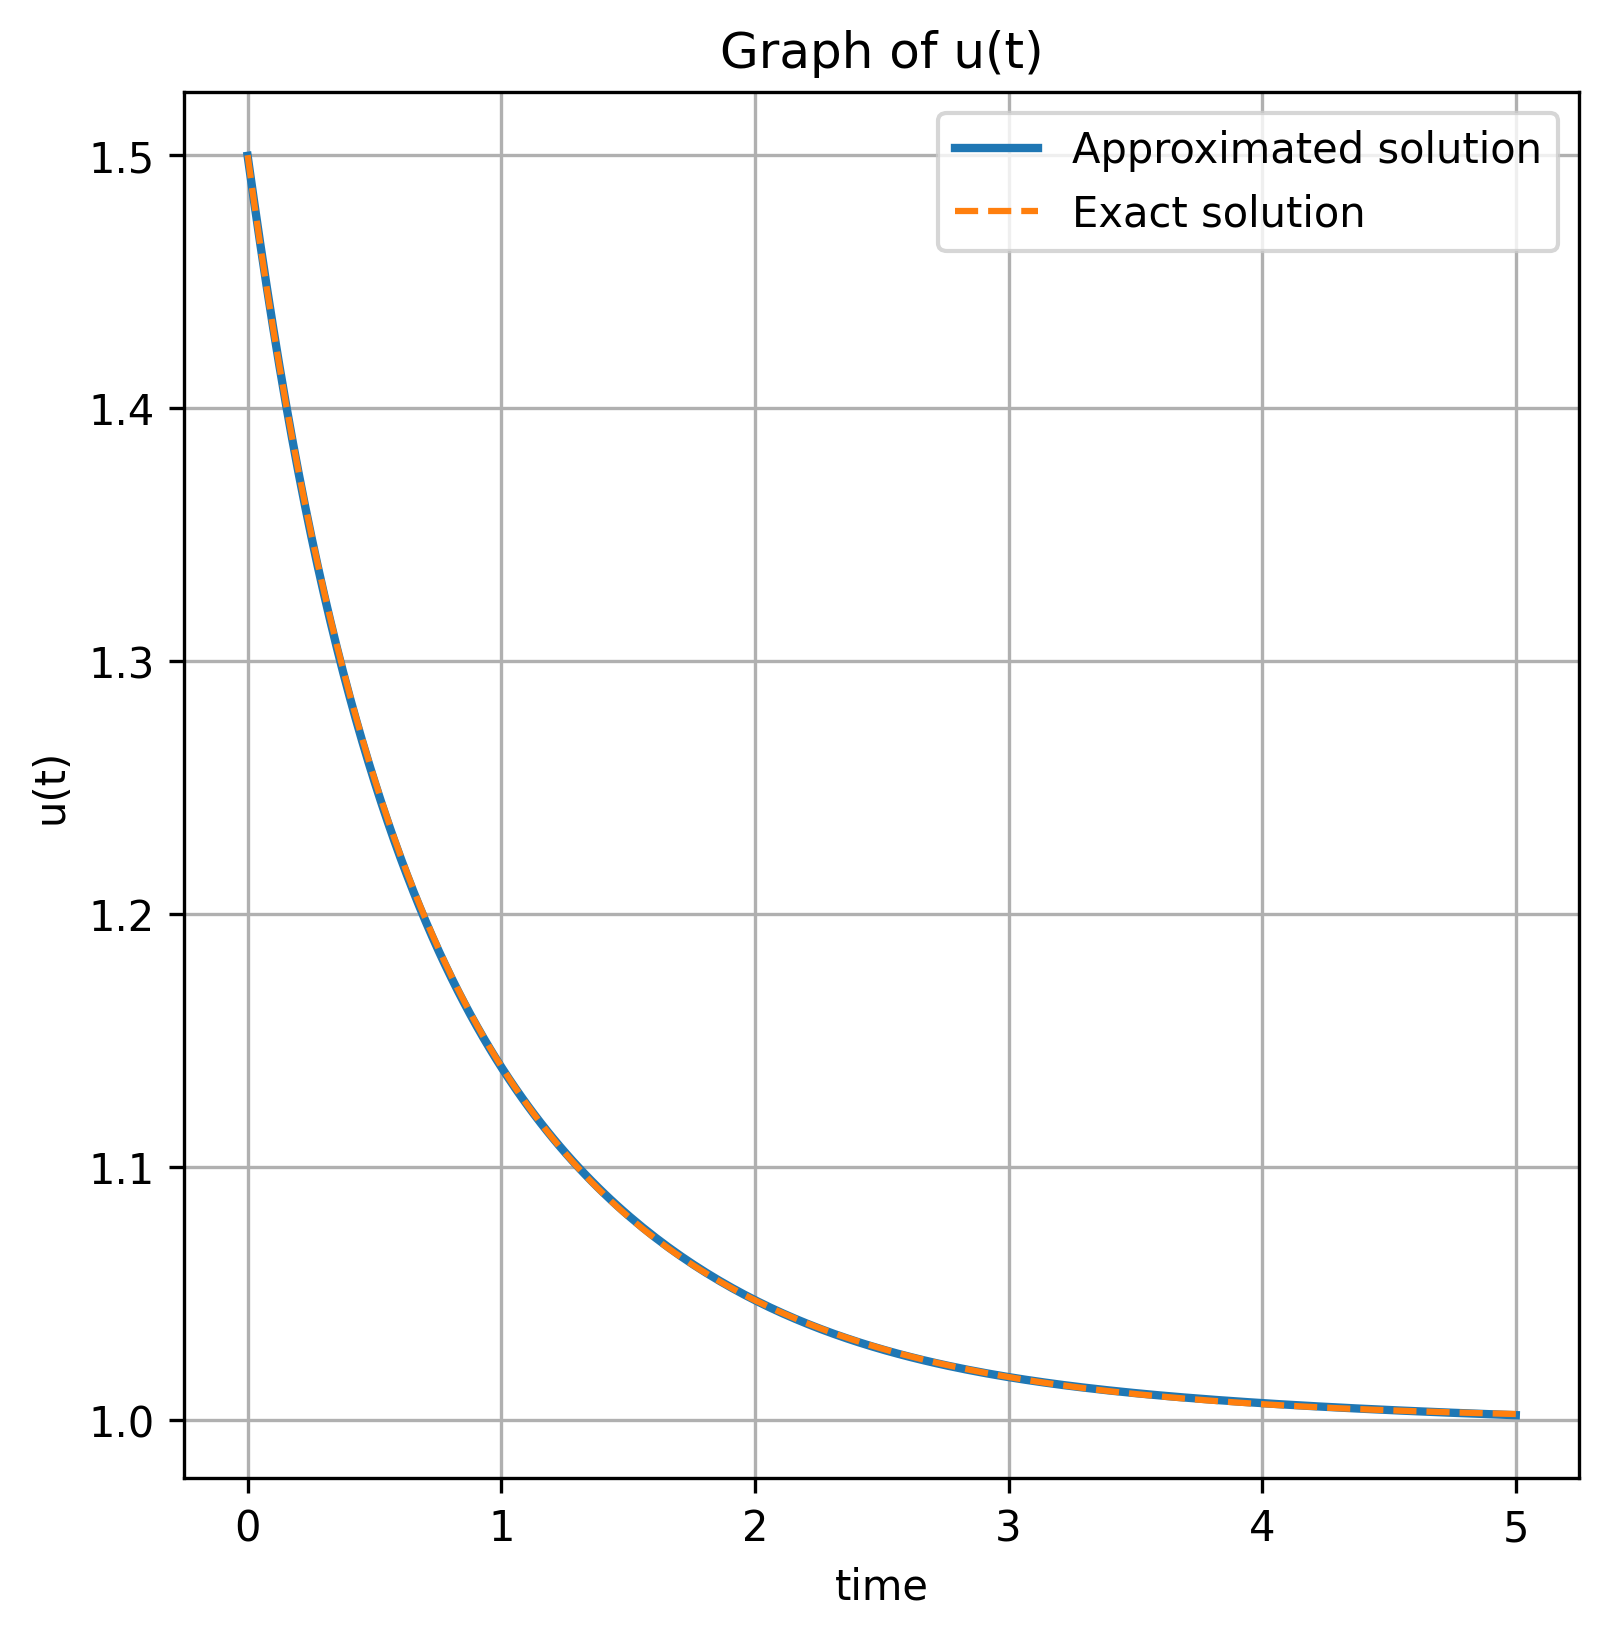

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Definizione della rete neurale
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, t):
        return self.net(t)

# Inizializzazione
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Parametri del problema
y0 = 1.5
T = 5.0

# Funzione di loss
def loss_fn(t_train):
    t_train.requires_grad = True
    y_hat = model(t_train)

    dy_dt = torch.autograd.grad(
        y_hat, t_train,
        grad_outputs=torch.ones_like(y_hat),
        create_graph=True
    )[0]

    ode_residual = dy_dt - y_hat * (1 - y_hat)
    ode_loss = torch.mean(ode_residual**2)

    # Condizione iniziale
    t0 = torch.tensor([[0.0]], dtype=torch.float32)
    y0_hat = model(t0)
    ic_loss = (y0_hat - y0)**2

    return ode_loss + ic_loss

# Training
epochs = 1000
t_train = torch.linspace(0, T, 100).view(-1, 1)

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_fn(t_train)
    if epoch ==0 or (epoch+1) %10==0 or epoch == epochs-1:
        print(f"Epoca: {epoch+1}, loss = {loss}")
    loss.backward()
    optimizer.step()

# Plotting la soluzione
t_test = torch.linspace(0, T, 200).view(-1, 1)
with torch.no_grad():
    y_pred = model(t_test).numpy()

# Soluzione analitica (per confronto)
t_np = t_test.numpy().flatten()
y_exact = 1 / (1 + ((1 / y0 - 1) * np.exp(-t_np)))

plt.figure(figsize=(6, 6), dpi=300)
plt.plot(t_np, y_pred, label='Approximated solution', linewidth=2)
plt.plot(t_np, y_exact, label='Exact solution', linestyle='--')
plt.xlabel("time")
plt.ylabel("u(t)")
plt.legend()
plt.title("Graph of u(t)")
plt.grid(True)
plt.show()


Epoca: 1, loss = 3.385207176208496
Epoca: 10, loss = 1.0873360633850098
Epoca: 20, loss = 0.37118014693260193
Epoca: 30, loss = 0.33720672130584717
Epoca: 40, loss = 0.20424515008926392
Epoca: 50, loss = 0.19530558586120605
Epoca: 60, loss = 0.15203747153282166
Epoca: 70, loss = 0.1324053406715393
Epoca: 80, loss = 0.10787978023290634
Epoca: 90, loss = 0.09219632297754288
Epoca: 100, loss = 0.07623901963233948
Epoca: 110, loss = 0.06203824281692505
Epoca: 120, loss = 0.05344362556934357
Epoca: 130, loss = 0.037590913474559784
Epoca: 140, loss = 0.03414535149931908
Epoca: 150, loss = 0.03171992674469948
Epoca: 160, loss = 0.027316942811012268
Epoca: 170, loss = 0.022675953805446625
Epoca: 180, loss = 0.020410124212503433
Epoca: 190, loss = 0.017221152782440186
Epoca: 200, loss = 0.01591850444674492
Epoca: 210, loss = 0.015148326754570007
Epoca: 220, loss = 0.012984272092580795
Epoca: 230, loss = 0.010590901598334312
Epoca: 240, loss = 0.011368835344910622
Epoca: 250, loss = 0.0101635921

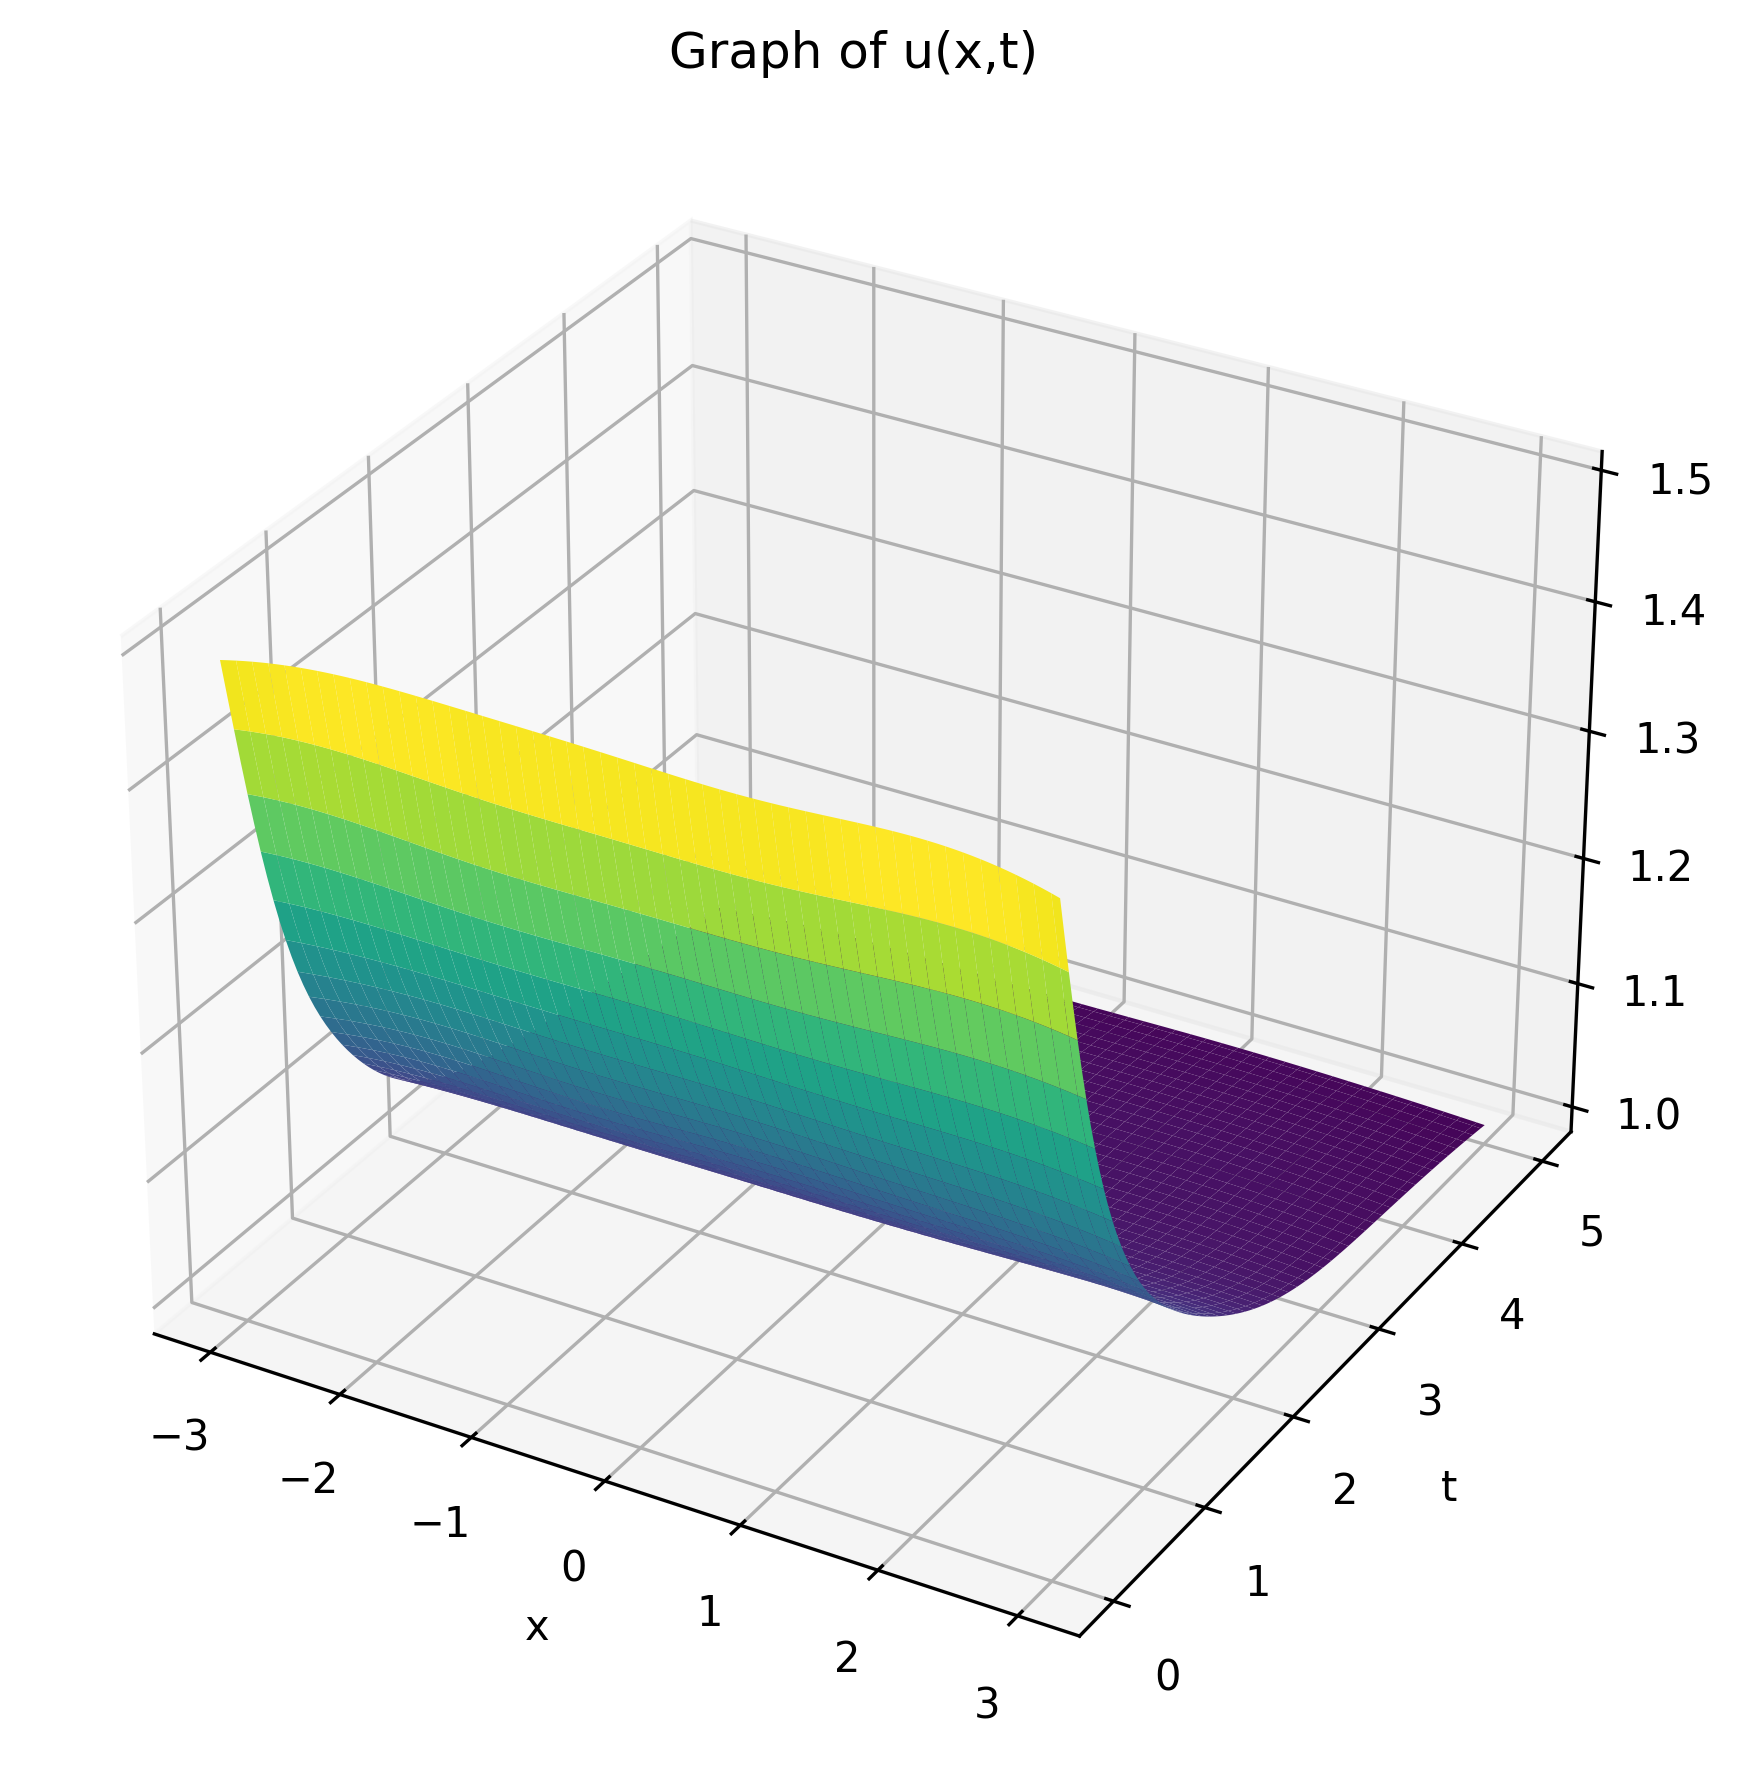

In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Costanti del problema
a, b = -3.0, 3.0
T = 5.0
y0_val = 1.5

# Soluzione analitica del bordo
def y_boundary(t):
    return y0_val * np.exp(t) / (1 + y0_val * (np.exp(t) - 1))

# Definizione della rete
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.net(inputs)

# Inizializzazione modello
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Funzione di loss
def loss_fn(x_interior, t_interior, x_bc, t_bc, y_bc_val, x_ic, t_ic):
    x_interior.requires_grad = True
    t_interior.requires_grad = True

    y_pred = model(x_interior, t_interior)

    # Derivata nel tempo
    dy_dt = torch.autograd.grad(y_pred, t_interior, grad_outputs=torch.ones_like(y_pred),
                                create_graph=True)[0]

    # Derivata seconda nello spazio
    dy_dx = torch.autograd.grad(y_pred, x_interior, grad_outputs=torch.ones_like(y_pred),
                                create_graph=True)[0]
    d2y_dx2 = torch.autograd.grad(dy_dx, x_interior, grad_outputs=torch.ones_like(dy_dx),
                                  create_graph=True)[0]

    # Residuo PDE: y_t - y_xx - y(1 - y)
    f = dy_dt - d2y_dx2 - y_pred * (1 - y_pred)
    pde_loss = torch.mean(f**2)

    # Condizione al bordo
    y_bc_pred = model(x_bc, t_bc)
    bc_loss = torch.mean((y_bc_pred - y_bc_val)**2)

    # Condizione iniziale
    y_ic_pred = model(x_ic, t_ic)
    ic_loss = torch.mean((y_ic_pred - y0_val)**2)

    return pde_loss + bc_loss + ic_loss

# Generazione dei punti
def generate_training_points(n_interior=1000, n_bc=200, n_ic=200):
    # Punti interni per la PDE
    x_int = torch.FloatTensor(n_interior, 1).uniform_(a, b)
    t_int = torch.FloatTensor(n_interior, 1).uniform_(0, T)

    # Punti per le condizioni al bordo
    t_bc = torch.FloatTensor(n_bc // 2, 1).uniform_(0, T)
    x_bc_left = torch.full_like(t_bc, a)
    x_bc_right = torch.full_like(t_bc, b)

    x_bc = torch.cat([x_bc_left, x_bc_right], dim=0)
    t_bc = torch.cat([t_bc, t_bc], dim=0)
    y_bc_val_np = y_boundary(t_bc.numpy())
    y_bc_val = torch.tensor(y_bc_val_np, dtype=torch.float32).view(-1, 1)

    # Punti per la condizione iniziale
    x_ic = torch.FloatTensor(n_ic, 1).uniform_(a, b)
    t_ic = torch.zeros_like(x_ic)

    return x_int, t_int, x_bc, t_bc, y_bc_val, x_ic, t_ic


epochs = 1000
# Training
for epoch in range(epochs):
    x_int, t_int, x_bc, t_bc, y_bc_val, x_ic, t_ic = generate_training_points()
    optimizer.zero_grad()
    loss = loss_fn(x_int, t_int, x_bc, t_bc, y_bc_val, x_ic, t_ic)
    if epoch ==0 or (epoch+1) %10==0 or epoch == epochs-1:
        print(f"Epoca: {epoch+1}, loss = {loss}")
    loss.backward()
    optimizer.step()


# Visualizzazione
x = torch.linspace(a, b, 100)
t = torch.linspace(0, T, 100)
X, T_grid = torch.meshgrid(x, t, indexing='ij')

x_flat = X.reshape(-1, 1)
t_flat = T_grid.reshape(-1, 1)

with torch.no_grad():
    y_pred = model(x_flat, t_flat).reshape(100, 100).numpy()

from mpl_toolkits.mplot3d import Axes3D  # Import necessario per i grafici 3D

# Griglia di punti
x = torch.linspace(a, b, 100)
t = torch.linspace(0, T, 100)
X, T_grid = torch.meshgrid(x, t, indexing='ij')

x_flat = X.reshape(-1, 1)
t_flat = T_grid.reshape(-1, 1)

# Predizione della rete
with torch.no_grad():
    y_pred = model(x_flat, t_flat).reshape(100, 100).numpy()

# Plot 3D
fig = plt.figure(figsize=(10, 6), dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X.numpy(), T_grid.numpy(), y_pred, cmap='viridis')

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('')
ax.set_title('Graph of u(x,t)')

plt.tight_layout()
plt.show()



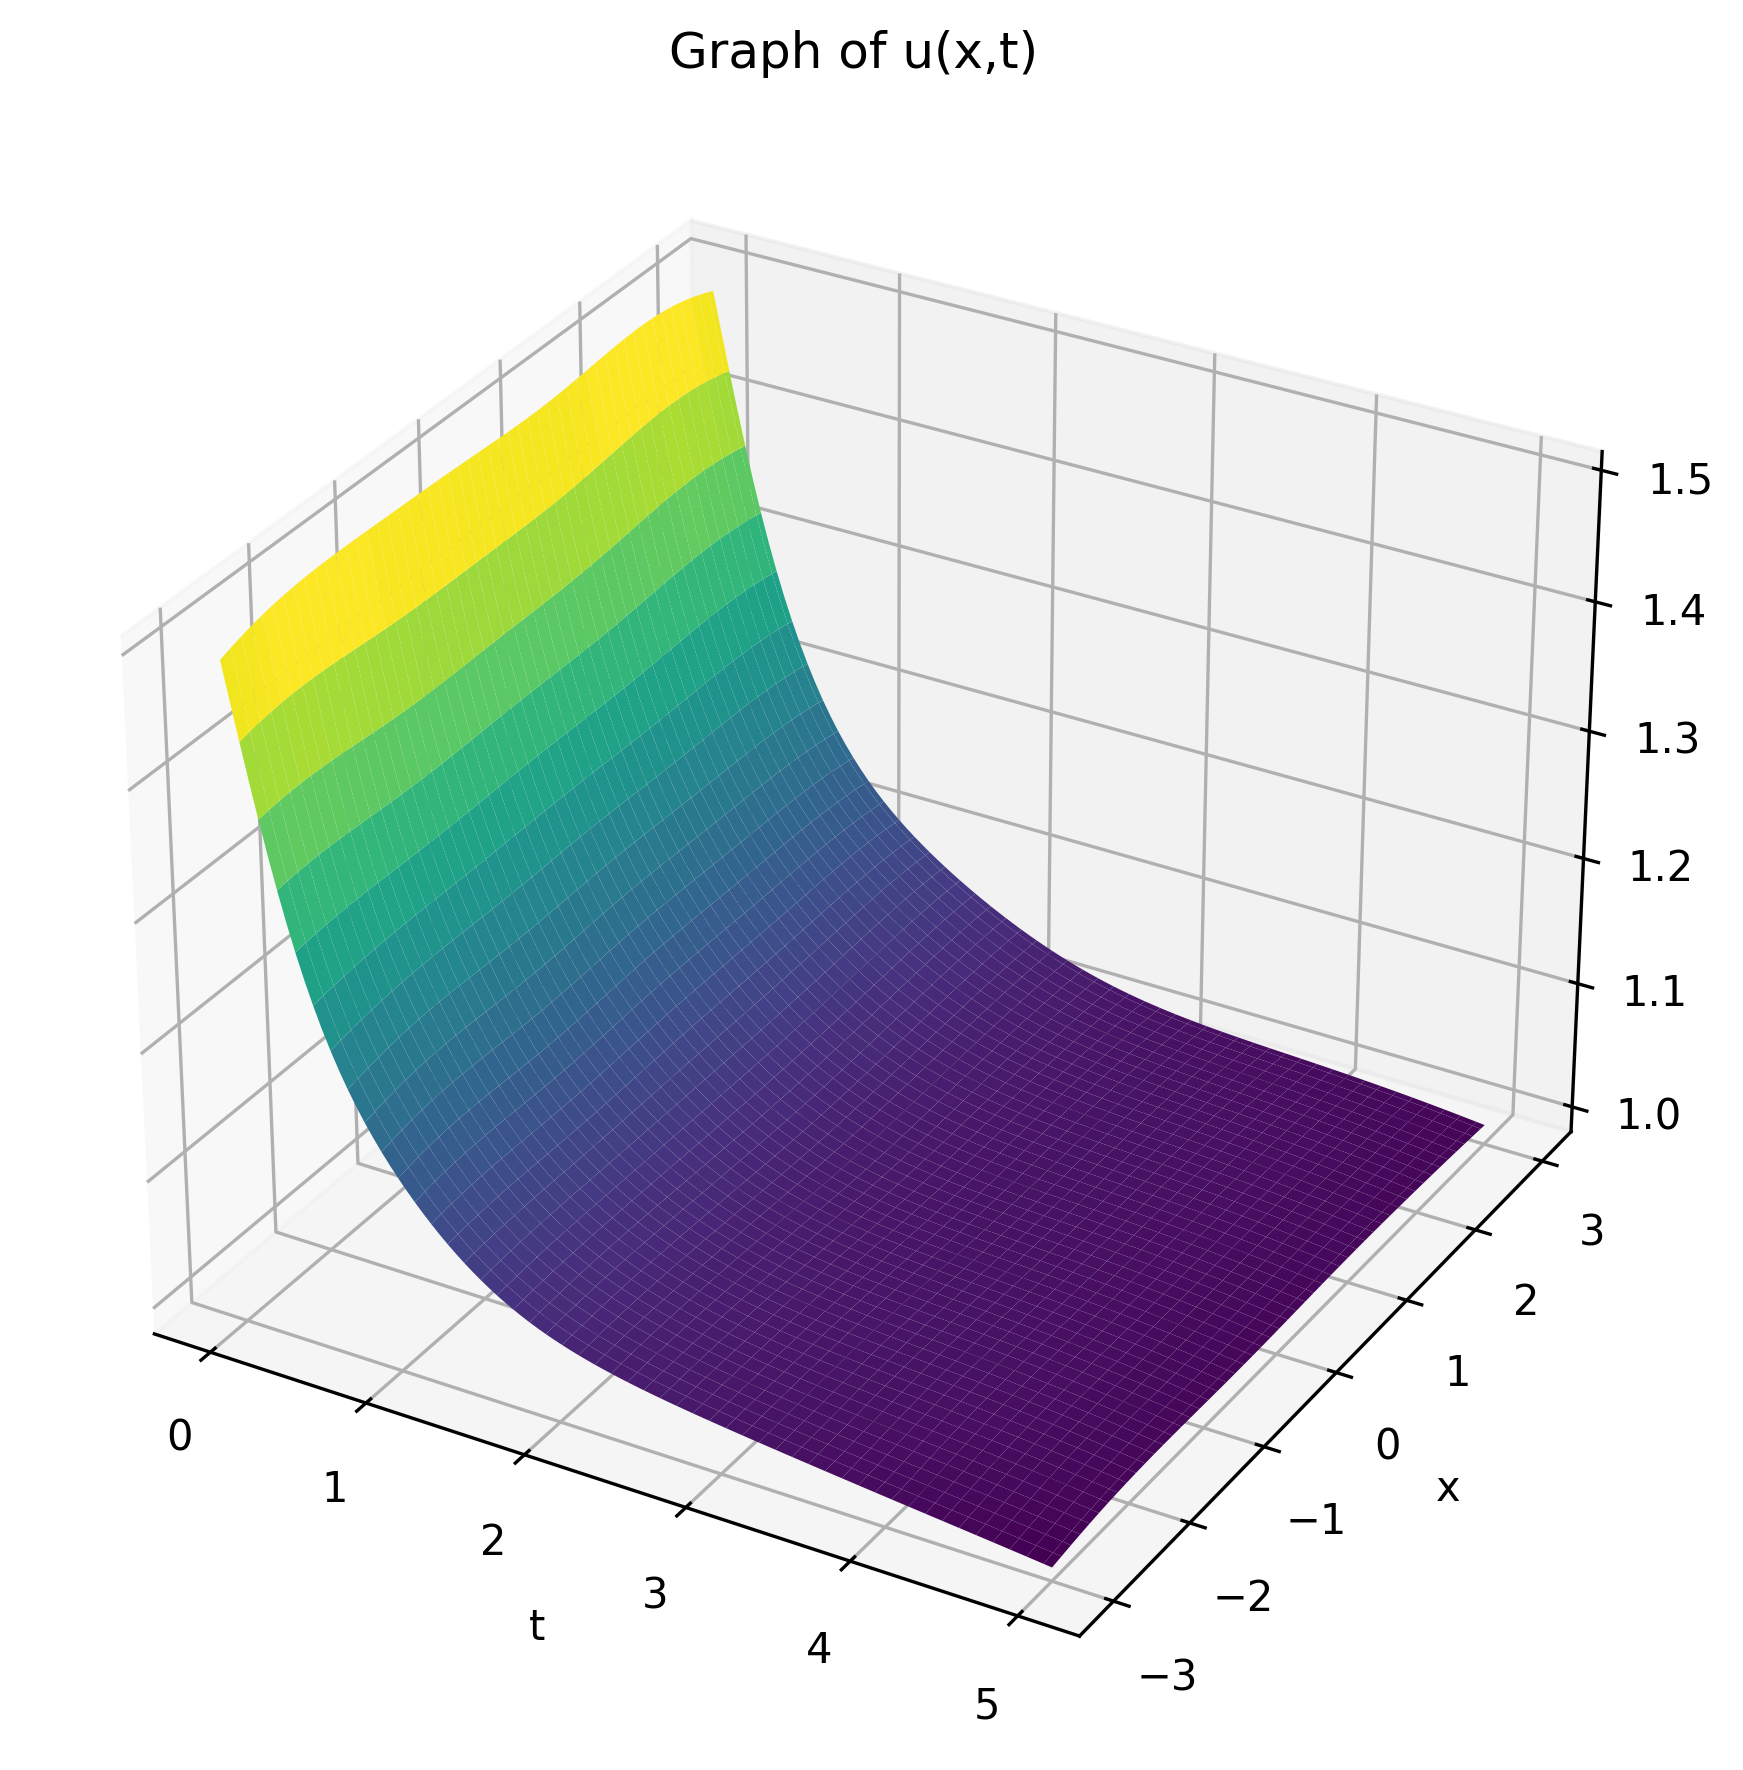

In [5]:
fig = plt.figure(figsize=(10, 6), dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T_grid.numpy(), X.numpy(), y_pred, cmap='viridis')

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('')
ax.set_title('Graph of u(x,t)')

plt.tight_layout()
plt.show()

Epoca: 1, loss = 7.7551984786987305
Epoca: 10, loss = 4.023157119750977
Epoca: 20, loss = 1.9386241436004639
Epoca: 30, loss = 1.2715117931365967
Epoca: 40, loss = 1.241237998008728
Epoca: 50, loss = 1.1367814540863037
Epoca: 60, loss = 1.0354247093200684
Epoca: 70, loss = 0.9630341529846191
Epoca: 80, loss = 0.8848114609718323
Epoca: 90, loss = 0.8070462942123413
Epoca: 100, loss = 0.7313107848167419
Epoca: 110, loss = 0.6583009958267212
Epoca: 120, loss = 0.5896618962287903
Epoca: 130, loss = 0.5261679887771606
Epoca: 140, loss = 0.4685097932815552
Epoca: 150, loss = 0.4166945815086365
Epoca: 160, loss = 0.3703573942184448
Epoca: 170, loss = 0.3290058970451355
Epoca: 180, loss = 0.2921823561191559
Epoca: 190, loss = 0.25948917865753174
Epoca: 200, loss = 0.23056581616401672
Epoca: 210, loss = 0.20505467057228088
Epoca: 220, loss = 0.18259339034557343
Epoca: 230, loss = 0.16283079981803894
Epoca: 240, loss = 0.14544054865837097
Epoca: 250, loss = 0.13012555241584778
Epoca: 260, loss =

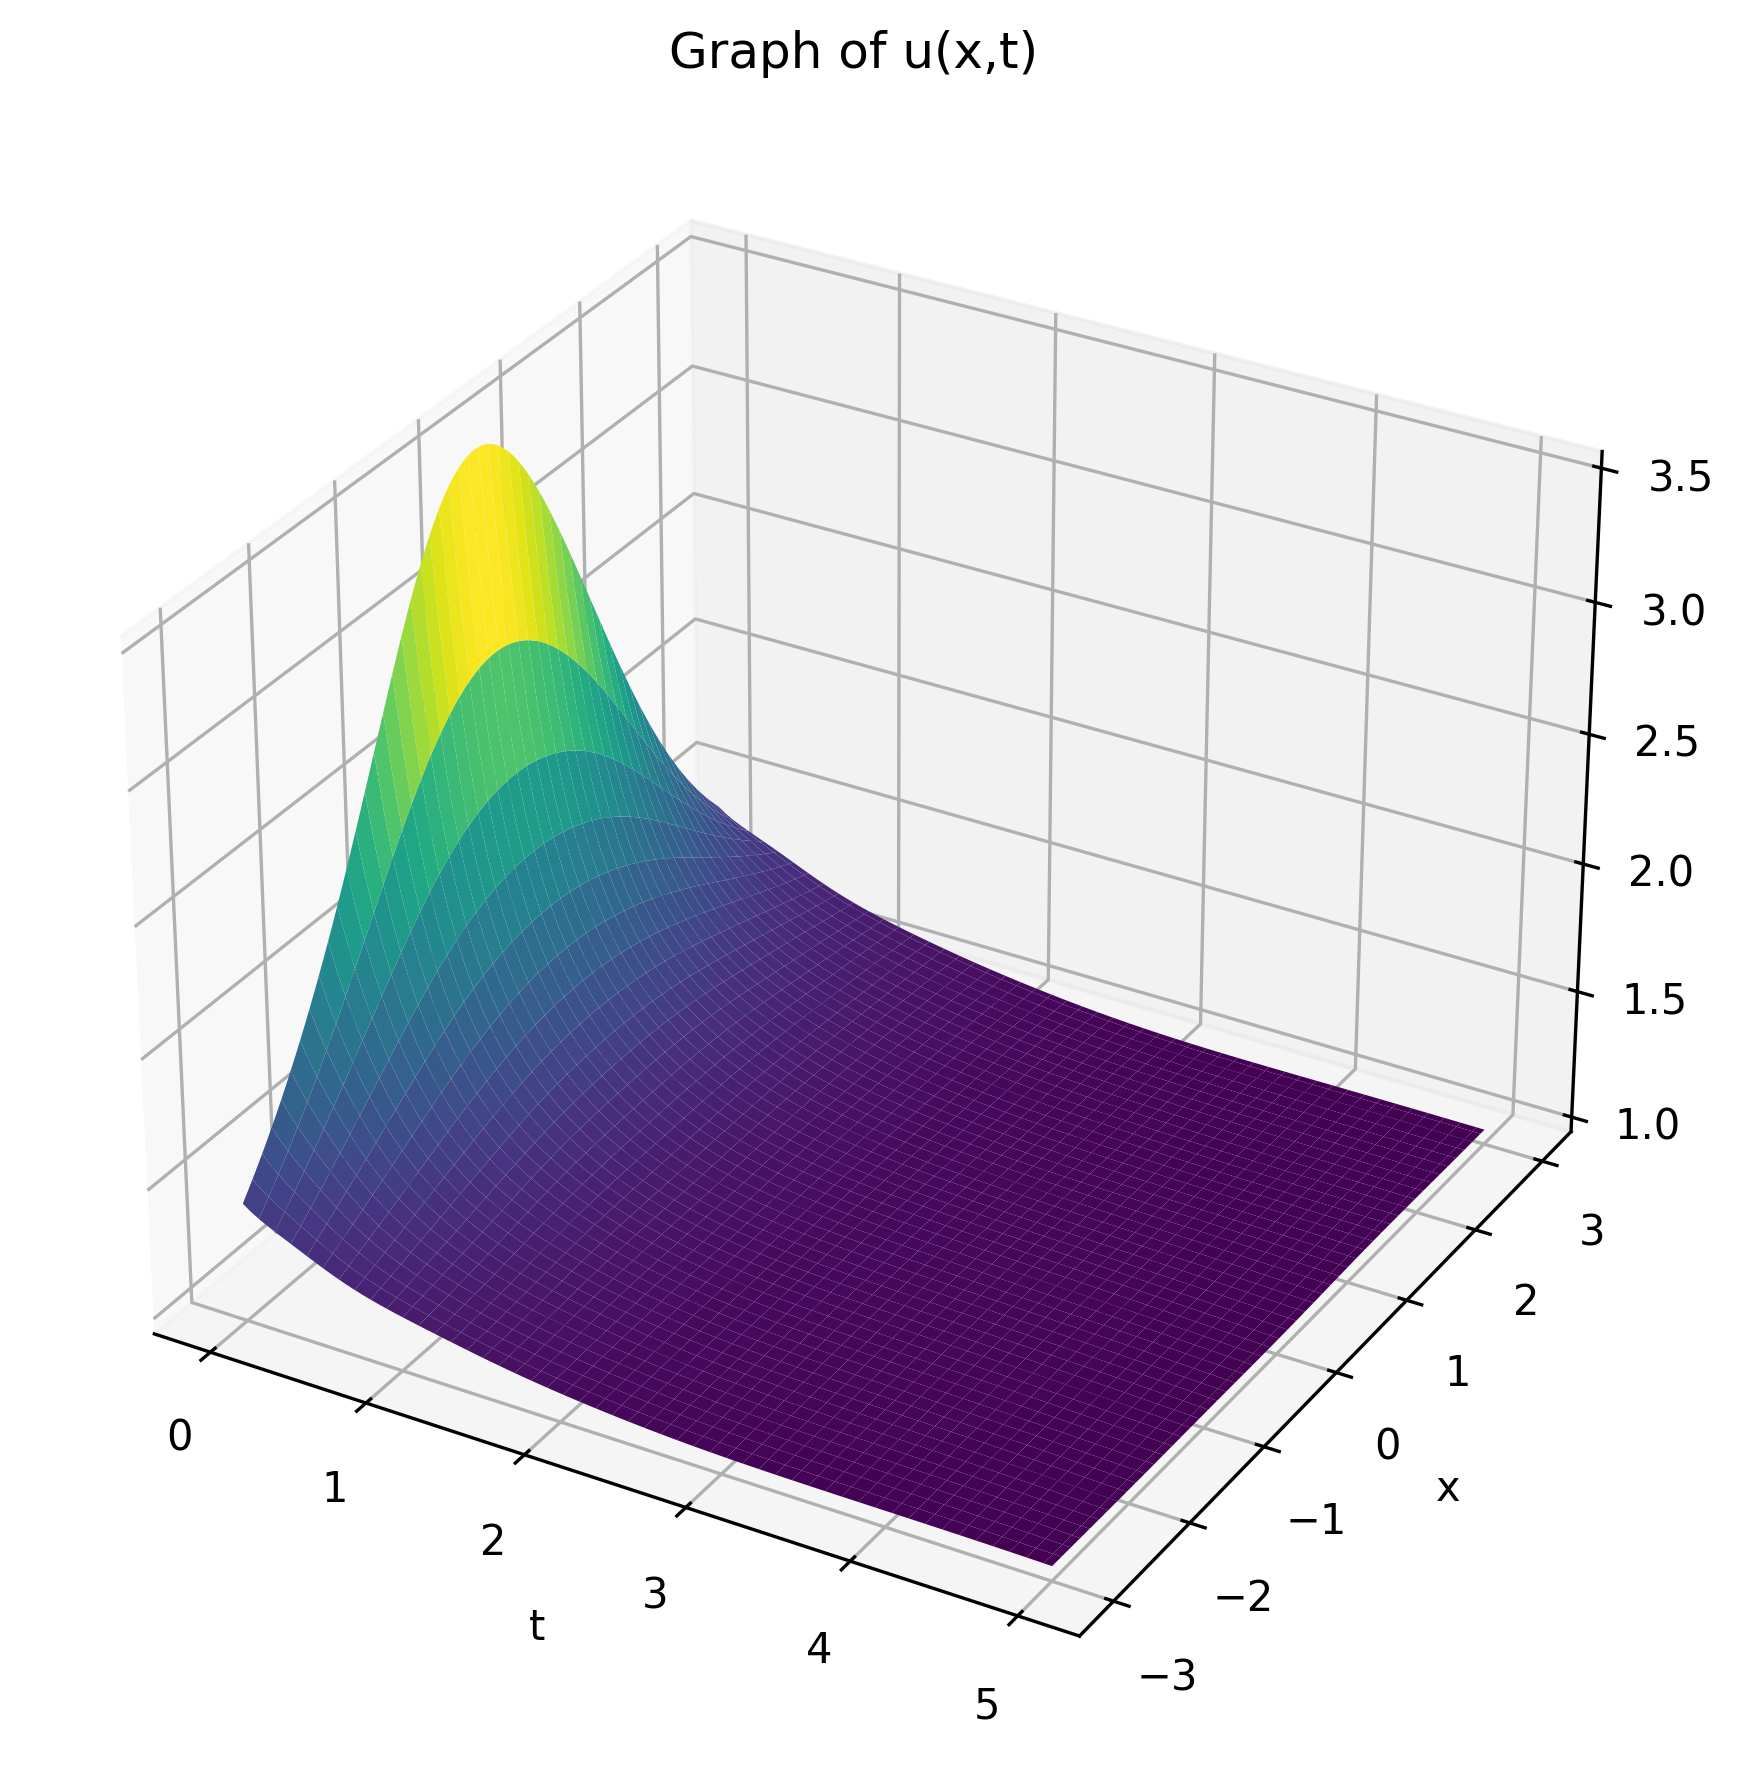

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Dominio
a, b = -3, 3
T = 5

# Inizializzazione funzione iniziale
def y0_fun(x):
    return torch.cos(np.pi/3 * x) + 2.5

# Condizione al bordo
def y_boundary(t):
    y0a = y0_fun(torch.tensor([a]))
    return (y0a * torch.exp(t)) / (1 + y0a * (torch.exp(t) - 1))

# Modello PINN
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.net(inputs)

# Loss
def loss_function(model, x_interior, t_interior, x_bc, t_bc, y_bc, x_ic, t_ic, y_ic):
    x_interior.requires_grad = True
    t_interior.requires_grad = True
    y = model(x_interior, t_interior)
    dy_dt = torch.autograd.grad(y, t_interior, torch.ones_like(y), create_graph=True)[0]
    dy_dx = torch.autograd.grad(y, x_interior, torch.ones_like(y), create_graph=True)[0]
    d2y_dx2 = torch.autograd.grad(dy_dx, x_interior, torch.ones_like(dy_dx), create_graph=True)[0]
    f = dy_dt - d2y_dx2 - y * (1 - y)
    loss_pde = torch.mean(f**2)

    loss_bc = torch.mean((model(x_bc, t_bc) - y_bc)**2)
    loss_ic = torch.mean((model(x_ic, t_ic) - y_ic)**2)

    return loss_pde + loss_bc + loss_ic

# Punti di training
N_f = 10000  # punti interni
N_bc = 200   # bordi
N_ic = 200   # iniziali

x_f = torch.FloatTensor(N_f, 1).uniform_(a, b)
t_f = torch.FloatTensor(N_f, 1).uniform_(0, T)

x_bc = torch.cat([torch.full((N_bc//2, 1), a), torch.full((N_bc//2, 1), b)], dim=0)
t_bc = torch.FloatTensor(N_bc, 1).uniform_(0, T)
y_bc = y_boundary(t_bc)

x_ic = torch.FloatTensor(N_ic, 1).uniform_(a, b)
t_ic = torch.zeros_like(x_ic)
y_ic = y0_fun(x_ic)

# Modello e ottimizzazione
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 1000
# Training
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_function(model, x_f, t_f, x_bc, t_bc, y_bc, x_ic, t_ic, y_ic)
    loss.backward()
    optimizer.step()
    if epoch ==0 or (epoch+1) %10==0 or epoch == epochs-1:
        print(f"Epoca: {epoch+1}, loss = {loss}")

# Griglia per grafico
x = torch.linspace(a, b, 100)
t = torch.linspace(0, T, 100)
X, T_grid = torch.meshgrid(x, t, indexing='ij')

x_flat = X.reshape(-1, 1)
t_flat = T_grid.reshape(-1, 1)

with torch.no_grad():
    y_pred = model(x_flat, t_flat).reshape(100, 100).numpy()

# Grafico 3D con assi scambiati
fig = plt.figure(figsize=(6, 6), dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T_grid.numpy(), X.numpy(), y_pred, cmap='viridis')

ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_zlabel('')
ax.set_title('Graph of u(x,t)')

plt.tight_layout()
plt.show()
